In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ruggedness metric

Questions
1. What is the topological stability of a circuit?
2. What is the ruggedness of each circuit generated by the model?

In [107]:
from functools import partial
import json
import jax.numpy as jnp
import numpy as np
import os
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify, setup_model, make_rates, prep_sim, sim, prep_cfg, make_batch_symmetrical_matrices
from evoscaper.utils.math import arrayise


jax.config.update('jax_platform_name', 'gpu')


# jupyter nbconvert --to notebook --execute 07_ruggedness.ipynb --output=07_ruggedness_2.ipynb --ExecutePreprocessor.timeout=-1


In [108]:
use_loaded = True
top_write_dir = os.path.join('data', '07_ruggedness', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

dir_src = os.path.join('data', '01_cvae', '2025_01_23__15_38_01')
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
fn_saves = os.path.join(dir_src, 'saves_2025_01_23__15_38_01_sens')

In [109]:
saves_loaded = load_json_as_dict(fn_saves)

(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = arrayise(saves_loaded[str(list(saves_loaded.keys())[-1])]['params'])



In [90]:
config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
config_bio_u = config_bio['base_configs_ensemble']['generate_species_templates']
config_bio_u.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
input_species = data[data['sample_name'].notna()]['sample_name'].unique()
config_bio = prep_cfg(config_bio_u, input_species)

# Run verification

In [91]:
if use_loaded:
    analytics = load_json_as_dict(
        'data/02_cvae_verify/2025_01_17__16_33_03/analytics.json')
    fake_circuits = np.load('data/02_cvae_verify/2025_01_17__16_33_03/fake_circuits.npy')
    ts = np.load('data/02_cvae_verify/2025_01_17__16_33_03/ts.npy')
    y0m = np.load('data/02_cvae_verify/2025_01_17__16_33_03/y0m.npy')
    ys = np.load('data/02_cvae_verify/2025_01_17__16_33_03/ys.npy')
else:
    (
        analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
    ) = verify(params=params,
               rng=rng,
               decoder=decoder,
               df=df,
               cond=np.array([-0.1, 1.1]),
               config_bio=config_bio,
               config_norm_y=config_norm_y,
               config_dataset=config_dataset,
               config_model=config_model,
               x_datanormaliser=x_datanormaliser,
               x_methods_preprocessing=x_methods_preprocessing,
               y_datanormaliser=y_datanormaliser,
               output_species=config_dataset.output_species,
               signal_species=config_dataset.signal_species,
               input_species=data[data['sample_name'].notna()
                                  ]['sample_name'].unique(),
               n_to_sample=int(hpos['eval_n_to_sample']),
               visualise=False,
               top_write_dir=top_write_dir,
               return_relevant=True,
               impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                                   df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))

# Ruggedness functions

In [92]:
def calculate_ruggedness(interactions, eps_perc, analytics_original, analytic, input_species, config_dataset, config_bio):

    eps = eps_perc * np.abs(interactions).max()
    perturbations = jax.vmap(
        partial(create_perturbations, eps=eps))(interactions)

    analytics_perturbed, ys, ts, y0m, y00s, ts0 = simulate_perturbations(
        perturbations, config_dataset, config_bio, input_species)
    analytic_perturbed = jnp.array(
        analytics_perturbed[analytic]).reshape(*interactions.shape, -1)

    ruggedness = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
        analytic_perturbed, np.array(analytics_original[analytic])[:interactions.shape[0]][:, None, :])

    return ruggedness, (analytics_perturbed, ys, ts, y0m, y00s, ts0)


def create_perturbations(interactions, eps):

    interactions_expanded = jnp.ones(
        (len(interactions), len(interactions))) * interactions

    perturbations = interactions_expanded + \
        jnp.eye(len(interactions_expanded), len(interactions_expanded)) * eps

    return perturbations


def simulate_perturbations(interactions, config_dataset, config_bio, input_species):

    interactions_reshaped = make_batch_symmetrical_matrices(
        interactions.reshape(-1, interactions.shape[-1]), side_length=len(input_species))

    model_brn, qreactions, ordered_species, postproc = setup_model(
        interactions_reshaped, config_bio, input_species)

    forward_rates, reverse_rates = make_rates(
        config_dataset.x_type, interactions_reshaped, postproc)

    (signal_onehot, signal_target, y00, t0, t1, dt0, dt1, stepsize_controller, save_steps, max_steps, forward_rates, reverse_rates) = prep_sim(
        config_dataset.signal_species, qreactions, interactions_reshaped, config_bio, forward_rates, reverse_rates)

    #
    threshold = 0.01  # config_bio['simulation']['threshold_steady_states']
    #

    analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
                                            qreactions,
                                            signal_onehot, signal_target,
                                            t0, t1, dt0, dt1,
                                            save_steps, max_steps,
                                            stepsize_controller,
                                            threshold=threshold)

    return analytics, ys, ts, y0m, y00s, ts0


def calculate_ruggedness_from_perturbations(analytic_perturbed, analytic_og, eps):

    dp = (analytic_perturbed - analytic_og) / eps

    ruggedness = jnp.sqrt(jnp.nansum(jnp.square(dp), axis=0))

    return ruggedness

In [98]:
fake_circuits_f = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)

eps_perc = - 1e-1
eps = eps_perc * np.abs(fake_circuits_f).max()
print('eps:', eps)
ruggedness, _ = calculate_ruggedness(fake_circuits_f, eps_perc=eps_perc, analytics_original=analytics, analytic='sensitivity_wrt_species-6',
                                     input_species=input_species, config_dataset=config_dataset, config_bio=config_bio)

eps: -0.29999998
Steady states found. Now calculating signal response


In [ ]:
np.save(os.path.join(top_write_dir, 'ruggedness.npy'), ruggedness)
for i, l in zip(_[1:], ['ys.npy', 'ts.npy', 'y0m.npy', 'y00s.npy', 'ts0.npy']):
    np.save(os.path.join(top_write_dir, l), i)
json.dump(analytics, open(os.path.join(top_write_dir, 'analytics.json'), 'w'))
print(top_write_dir)

data/07_ruggedness/2025_01_24__16_55_01


# Visualise

([], [])

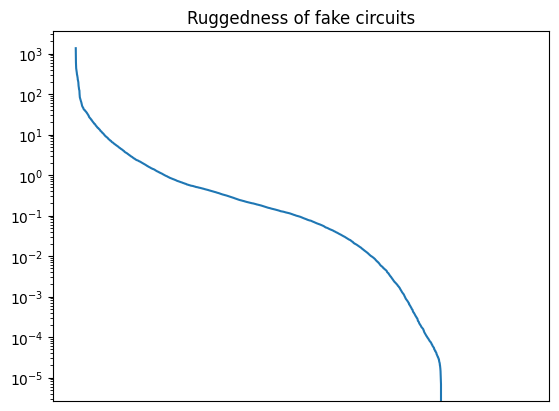

In [ ]:
stop
fake_circuits_f = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)
ruggedness_loaded = np.load(os.path.join('data/07_ruggedness/2025_01_24__16_55_01', 'ruggedness.npy'))
analytics_perturbed = load_json_as_dict(os.path.join('data/07_ruggedness/2025_01_24__16_55_01', 'analytics.json'))
analytic_perturbed = np.array(analytics_perturbed['sensitivity_wrt_species-6'])
analytic_og = np.array(analytics['sensitivity_wrt_species-6'])
eps_perc=1e-3
eps = eps_perc * np.abs(fake_circuits_f).max()
dp = (analytic_perturbed - analytic_og) / eps
output_idx = -1
sns.lineplot(x=np.arange(len(fake_circuits_f)), y=np.sort(ruggedness_loaded[:, output_idx])[::-1])
plt.yscale('log')
plt.title('Ruggedness of fake circuits')
plt.xticks([])

In [105]:
np.sum(analytic_perturbed - analytic_og == 0) / np.prod(analytic_perturbed.shape)

np.sum((analytic_perturbed / analytic_og) == 1)

np.int64(51079)

In [69]:
import itertools
idxs_plot = sorted(set([tuple(np.sort([i, j]).tolist()) for i, j in itertools.product(np.arange(fake_circuits_f.shape[-1]), np.arange(fake_circuits_f.shape[-1])) if i != j]))
len(idxs_plot)

15

/tmp/ipykernel_997865/3530162470.py:1: RuntimeWarning: divide by zero encountered in log10
  ruggedness_log = np.where(np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)


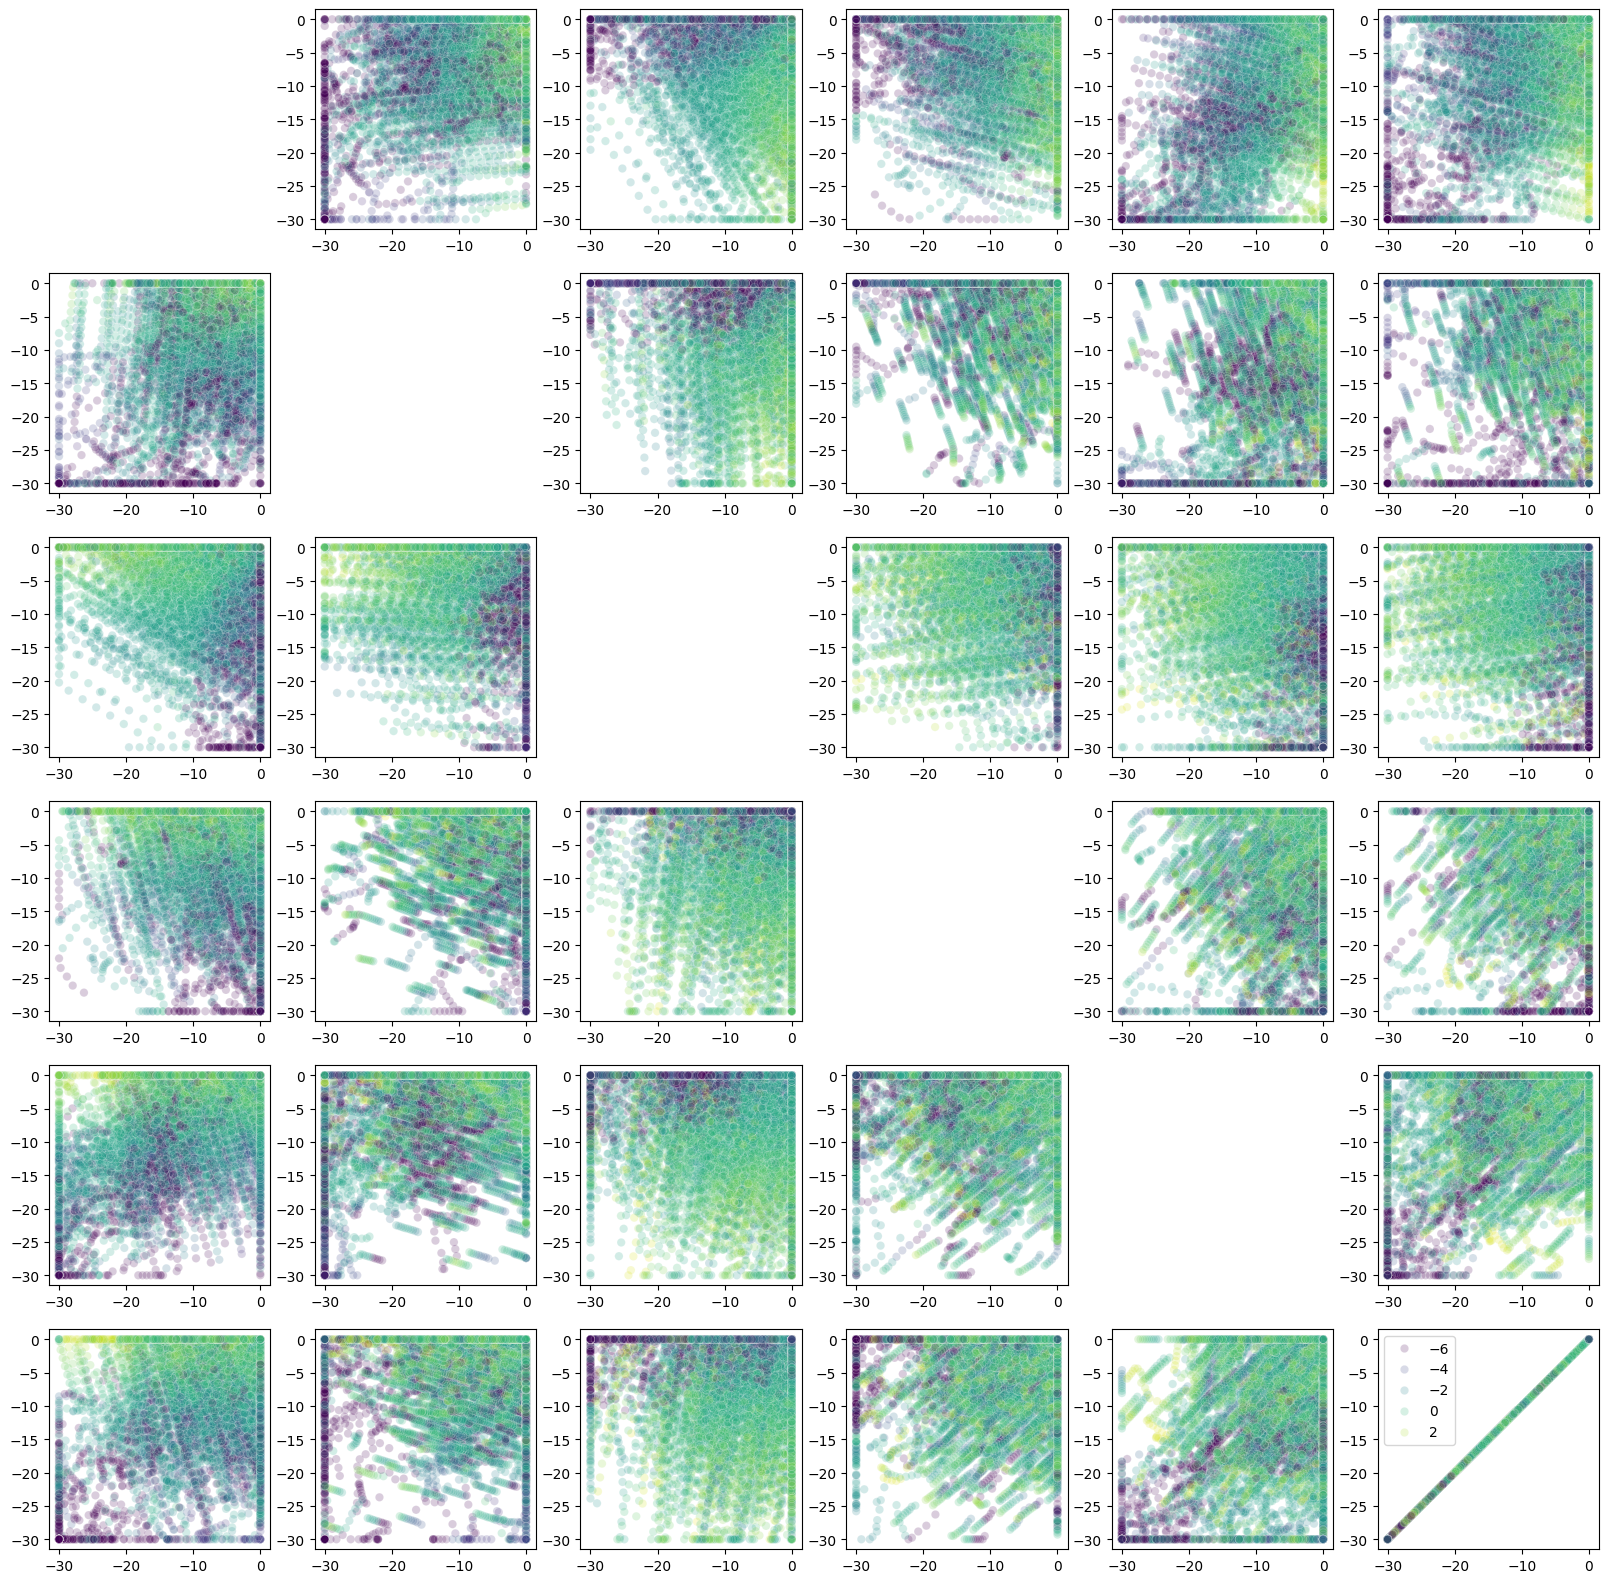

In [ ]:
ruggedness_log = np.where(np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)

plt.figure(figsize=(20, 20))
for i in range(fake_circuits_f.shape[-1]):
    for j in range(fake_circuits_f.shape[-1]):
        is_final = (i == fake_circuits_f.shape[-1] - 1) & (j == fake_circuits_f.shape[-1] - 1)
        if i != j or is_final:
            plt.subplot(fake_circuits_f.shape[-1], fake_circuits_f.shape[-1], i * fake_circuits_f.shape[-1] + j + 1)
            sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=ruggedness_log[:, output_idx], palette='viridis', alpha=0.2, legend=True if is_final else False)
            # sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=None, palette='viridis', alpha=0.2, legend=True if is_final else False)